In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

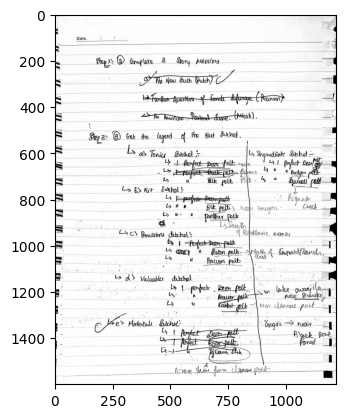

In [3]:
image = cv2.imread("./handwritten.jpg", 0)

plt.imshow(image, cmap='grey')

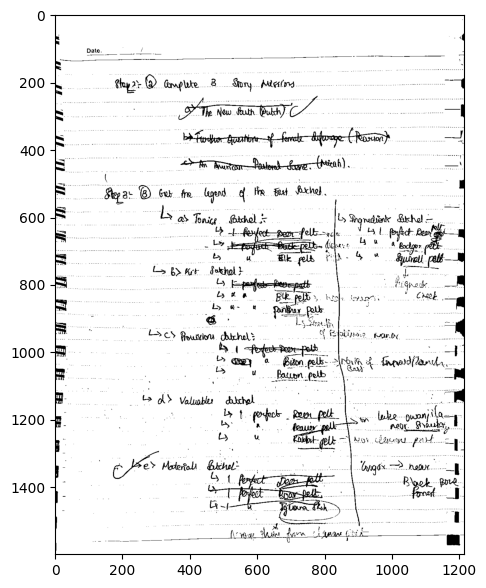

In [4]:
retval, binary = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(12,7))

plt.imshow(binary, cmap='grey')
plt.show()

In [5]:
# Adaptive thresholding

adaptive_m = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 15)

adaptive_g = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 15)

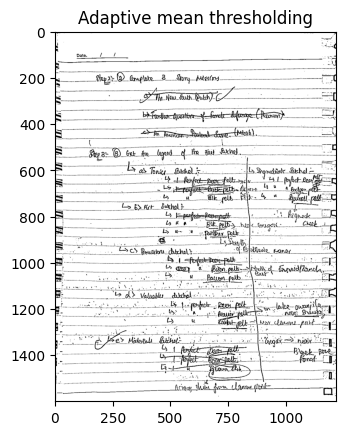

In [6]:
plt.imshow(adaptive_m, cmap='grey')
plt.title("Adaptive mean thresholding")
plt.show()

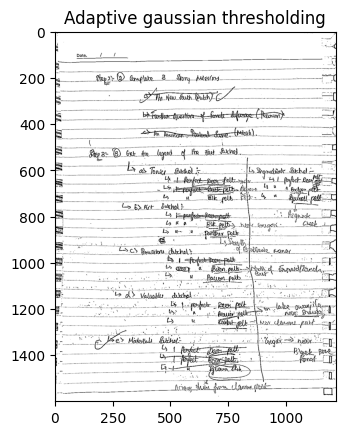

In [8]:
plt.imshow(adaptive_g, cmap='grey')
plt.title("Adaptive gaussian thresholding")
plt.show()

In [ ]:
# K- means clustering

image = cv2.imread("./shapes.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pixel_values = image.reshape((-1, 3))
pixel_values = np.float32(pixel_values)


[[254. 254. 254.]
 [254. 254. 254.]
 [254. 254. 254.]
 ...
 [254. 254. 254.]
 [254. 254. 254.]
 [254. 254. 254.]]


In [11]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
k = 3

_, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

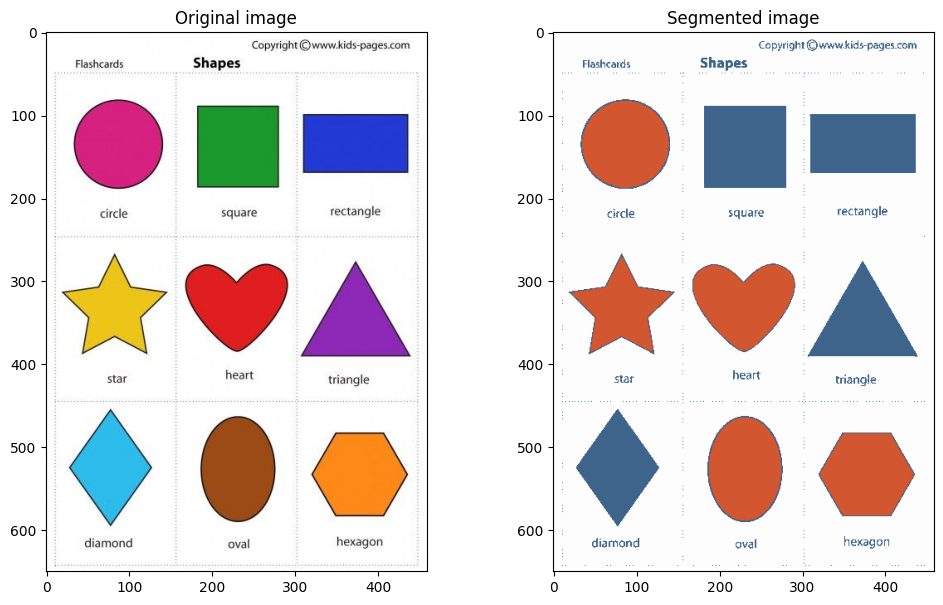

In [13]:
centers = np.uint8(centers)
segmented_image = centers[labels.flatten()]
segmented_image = segmented_image.reshape(image.shape)

# Creating subplots

plt.figure(figsize=(12,7))

plt.subplot(1,2,1)
plt.imshow(image)
plt.title("Original image")

plt.subplot(1,2,2)
plt.imshow(segmented_image)
plt.title("Segmented image")

plt.show()

## Watershed algorithm

In [69]:
coin_image = cv2.imread("./coins.jpg")
coin_image_rgb = cv2.cvtColor(coin_image, cv2.COLOR_BGR2RGB)

In [70]:
coin_image_original = coin_image.copy()

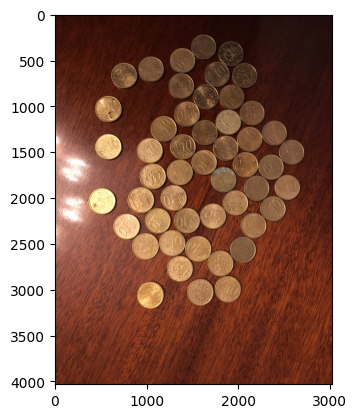

In [24]:
plt.imshow(coin_image_rgb)

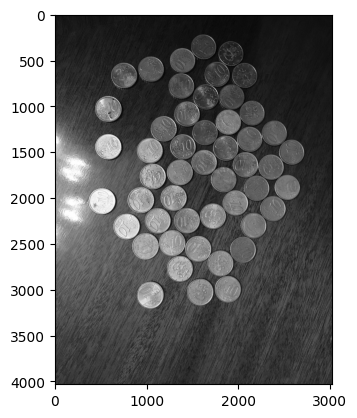

In [25]:
image_gray = cv2.cvtColor(coin_image, cv2.COLOR_BGR2GRAY)
plt.imshow(image_gray, cmap='gray')

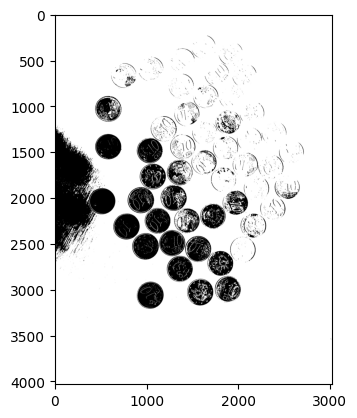

In [ ]:
## Thresholding

_, thresh = cv2.threshold(image_gray, 130,255, cv2.THRESH_BINARY_INV)

plt.imshow(thresh, cmap='gray')

In [30]:
## Noise removal - using morphology

kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=4)

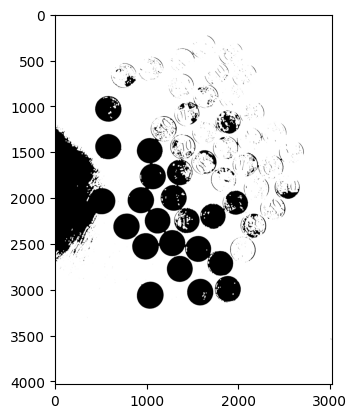

In [31]:
plt.imshow(opening, cmap='gray')

In [47]:
# Background removal

sure_bg = cv2.dilate(opening, kernel, iterations = 3)

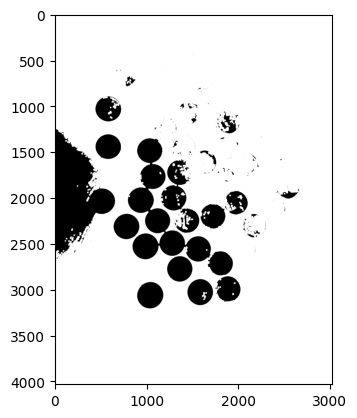

In [48]:
plt.imshow(sure_bg, cmap='gray')

In [49]:
# Foreground seperation
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2,5)

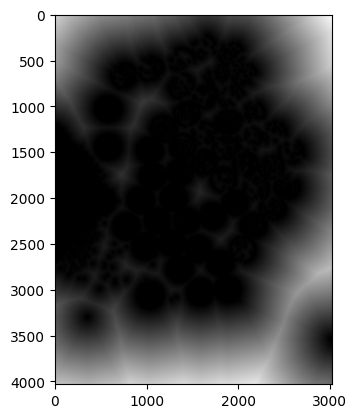

In [50]:
plt.imshow(dist_transform, cmap='gray')

In [54]:
_, sure_fg = cv2.threshold(dist_transform, 0.2 * dist_transform.max(),255,0)
sure_fg = np.uint8(sure_fg)

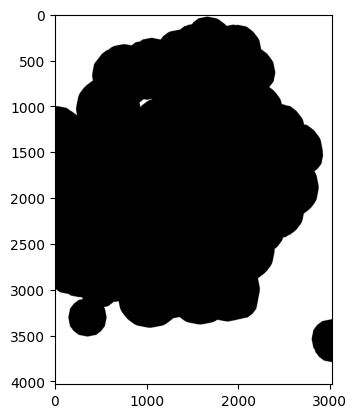

In [55]:
plt.imshow(sure_fg, cmap='gray')

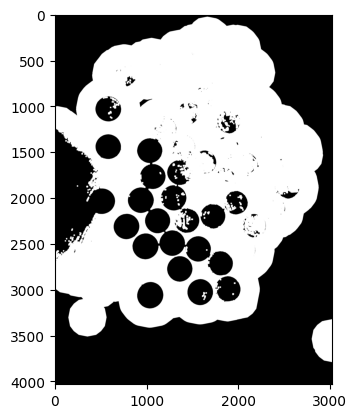

In [56]:
# Unclear/ Unknown region

unknown = cv2.subtract(sure_bg, sure_fg)
plt.imshow(unknown, cmap='gray')

In [57]:
# Finding markers

_, markers = cv2.connectedComponents(sure_fg)

In [58]:
markers = markers + 1
markers[unknown == 255] = 0

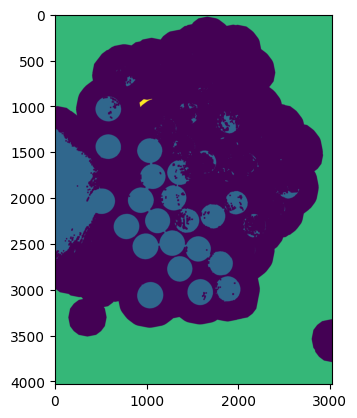

In [59]:
plt.imshow(markers)

In [61]:
# Watershed

new_markers = cv2.watershed(coin_image,markers)

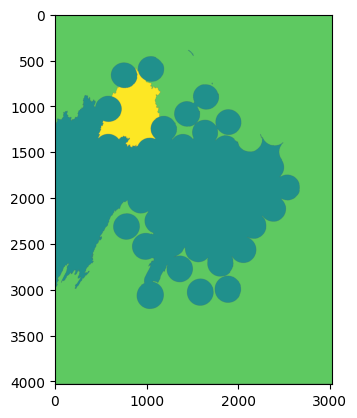

In [63]:
plt.imshow(new_markers)

In [64]:
# Saving interested componenets

coin_mask = np.zeros_like(image_gray)

In [65]:
if image_gray.shape == coin_mask.shape:
    pass

In [66]:
unique_labels = np.unique(markers)

In [71]:
instance_number = 1
font = cv2.FONT_HERSHEY_COMPLEX

for label in unique_labels:
    if label == 0 or label == -1:
        continue
    
    mask = np.uint8(markers == label)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)

        if perimeter == 0:
            continue
        
        circularity = 4 * np.pi * (area / (perimeter*perimeter))

        if 0.7 < circularity < 1.2 and area>1000:
            cv2.drawContours(coin_image_original, [contour], -1, (0,255,0),2 )
            x,y,w,h = cv2.boundingRect(contour)
            cv2.putText(coin_image_original, f"Coin {instance_number}",(x,y-10,), font, 0.6, (255,0,0),2)
            coin_mask = cv2.bitwise_or(coin_mask, mask)
            cv2.rectangle(coin_image_original, (x-5,y-5),(x+w+5, y+h+5), (160,150,250),2)
            instance_number += 1


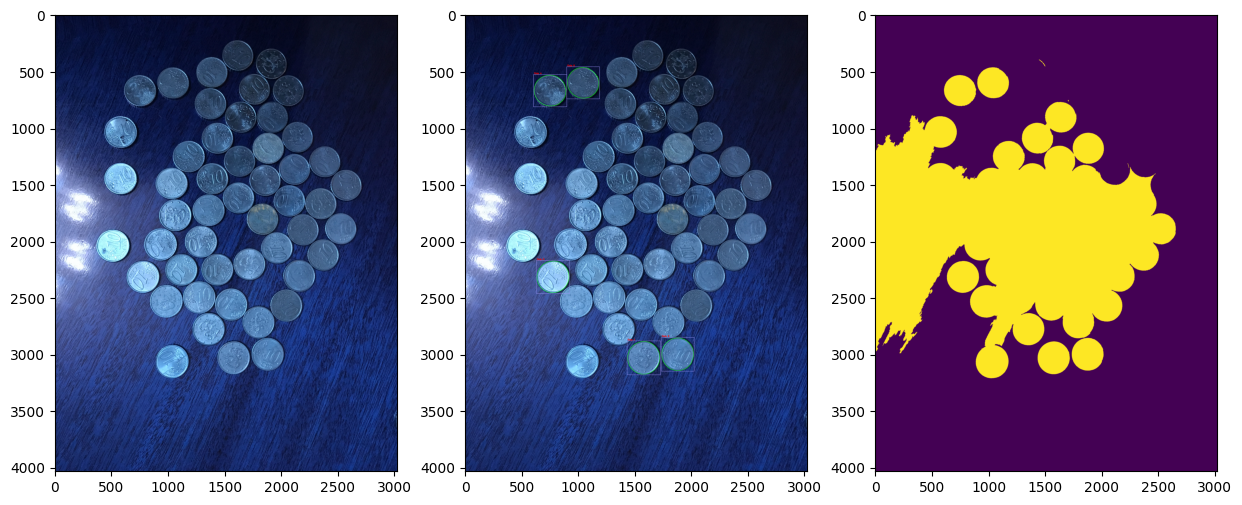

In [72]:
plt.figure(figsize=(15,10))

plt.subplot(1,3,1)
plt.imshow(coin_image)

plt.subplot(1,3,2)
plt.imshow(coin_image_original)

plt.subplot(1,3,3,)
plt.imshow(coin_mask)